# Lecture 02 GARCH

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [12]:
def garch(param, *args):
    # Initialize Params
    mu = param[0]                     # Mean of the returns
    omega = param[1]                  # Long-run average variance (constant term)
    alpha = param[2]                  # Coefficient for the ARCH term (past return squared)
    beta = param[3]                   # Coefficient for the GARCH term (past volatility)

    # Initialize dictionaries to store calculated values
    GARCH_Dens, sigma2, F, v = {}, {}, {}, {} 

    # Initialize the first value of sigma2 with the variance of Y
    sigma2[0] = np.var(Y)             # Set initial variance (sigma^2) as variance of returns

    # Initialize the likelihood to accumulate log-likelihood values
    Likelihood = 0                    # Log-likelihood accumulator

    # Loop over each time step starting from 1 up to T (length of time series)
    for t in range(1, T):
        # Calculate time-varying volatility (variance)
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]  # Update variance based on previous return and volatility
        
        # Calculate the residual term with the estimated volatility (standard deviation)
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)     # Residuals from GARCH estimation

        # Store the time-varying variance for density calculation
        v[t] = sigma2[t]                # Store variance for current time step

        # Calculate log-density based on GARCH(1,1) model assumptions
        GARCH_Dens[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F[t] / v[t])  # GARCH density for t

        # Accumulate the negative log-likelihood over time steps
        Likelihood += GARCH_Dens[t]    # Accumulate likelihood

    # Return the accumulated negative log-likelihood as the function output
    return Likelihood                  # Return total log-likelihood


In [13]:
def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    sigma2, path = {}, {}
    # initialzie volatility and path
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        path[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
        
    return path, sigma2    

[*********************100%***********************]  1 of 1 completed

         Current function value: -4361.509678
         Iterations: 2
         Function evaluations: 165
         Gradient evaluations: 31
RMSE values is: 0.015757562229957056%


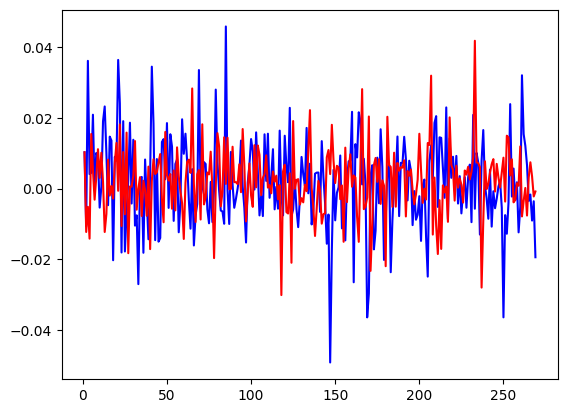

In [14]:
start_date = datetime(2023,1,1)
end_date = datetime(2024,1,31)
stock_symbol = 'AAPL'
stock = yf.download(stock_symbol,start_date ,end_date)
Y = np.diff(np.log(stock['Adj Close'].values))
T = Y.shape[0]
param0 = np.array([np.mean(Y), np.var(Y)/900, 0.44, 0.23]) # initial guess, mu=mean, omega=var/900, alpha=1.2, beta=0.25
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True}) # minimize the likelihood, and result stores the best score and the optimized parameters
param_star = results.x # store the optimized parameters

path, vol = garch_path(param_star, Y, T)
Y_GARCH = path.values() # bring the optimized values into a list
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y,'b',timevec, Y_GARCH,'r')

# Extracting the dictionary values into a list (in the same order as keys)
GARCH_prediction = list(Y_GARCH)

# Calculate RMSE
RMSE = np.sqrt(np.mean((np.array(GARCH_prediction ) - np.array(Y))**2)) # root mean squared error, map the values to an array and calculate the difference between the two arrays, square the difference, calculate the mean and take the square root
print(f'RMSE values is: {RMSE}%')

In [15]:
param_star

array([1.53662113e-03, 1.85052298e-07, 4.39999989e-01, 2.29999962e-01])